# Re-implementation of GBF in python

In [1]:
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import numpy as np
import jax
import jax.numpy as jnp
from pathlib import Path
import matplotlib.pyplot as plt
from methods.sarbm3d.sarbm3d import SARBM3D
from methods.gbf.gbf import BF
from scripts.enl import ENLClassifier
from scripts.io import read_image, save_image, KEY_INPUT_EO, KEY_INPUT_SAR, KEY_OUTPUT_SAR
from scripts.utils import c2ap, rgb2gray, T, invT

print(jax.devices())

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[CpuDevice(id=0)]


In [2]:
def Norm(sar):
    sar = jnp.array(sar)
    sar = (sar - sar.min()) / (sar.max() - sar.min())  # Normalize to [0, 1]
    return sar

def standardize(image):
    mean = jnp.mean(image)
    std = jnp.std(image)
    standardized_image = (image - mean) / std
    return standardized_image

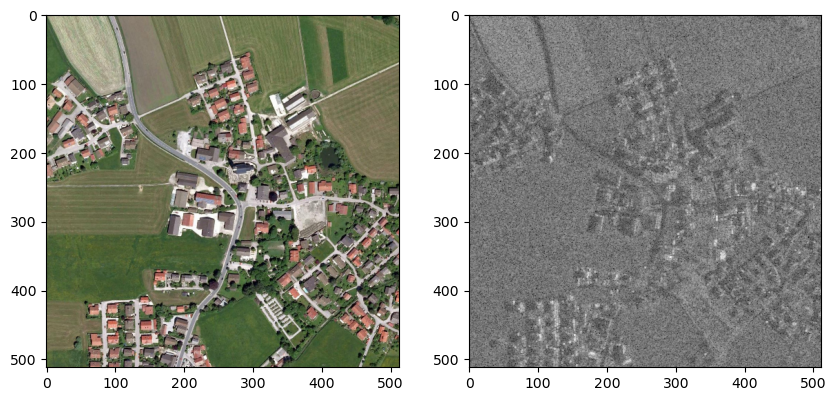

In [3]:
input_path = "../../dataset/data_village.npz"

eo = read_image(input_path, key=KEY_INPUT_EO)
sar = read_image(input_path, key=KEY_INPUT_SAR)

input_eo = jnp.array(eo)
input_sar = jnp.array(sar)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(eo)
plt.subplot(1, 2, 2)
plt.imshow(T(sar), cmap='gray')

### Apply SARBM3D

In [4]:
sarbm3d = SARBM3D(matlab_script_path='../../SARBM3D_v10_linux64/SARBM3D_v10.m')

sar_filtered_sarbm3d = sarbm3d.filter(input_sar, L=1)

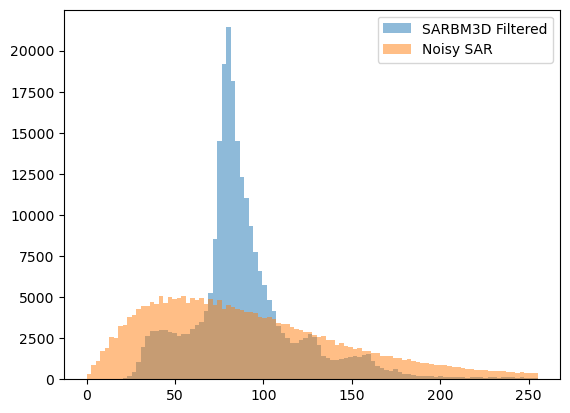

In [5]:
plt.hist(sar_filtered_sarbm3d.flatten(), bins=100, range=(0, 255), label='SARBM3D Filtered', alpha=0.5);
plt.hist(sar.flatten(), bins=100, range=(0, 255), label='Noisy SAR', alpha=0.5);
plt.legend();

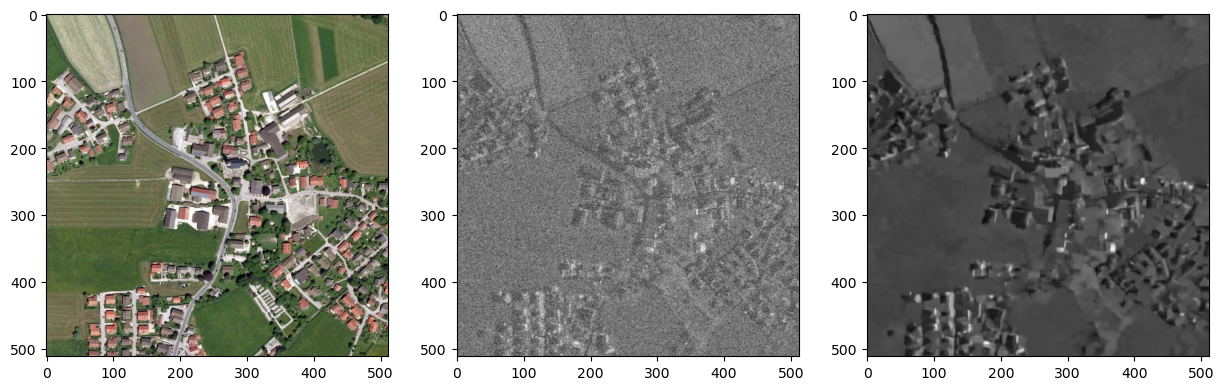

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(eo)
plt.subplot(1, 3, 2)
plt.imshow(T(sar), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(T(sar_filtered_sarbm3d), cmap='gray')

### ENL Classifier 

In [9]:
classifier = ENLClassifier()

weights = classifier.classify(input_sar, N=np.arange(7, 63, 2).tolist())

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:24<00:00,  1.15it/s]


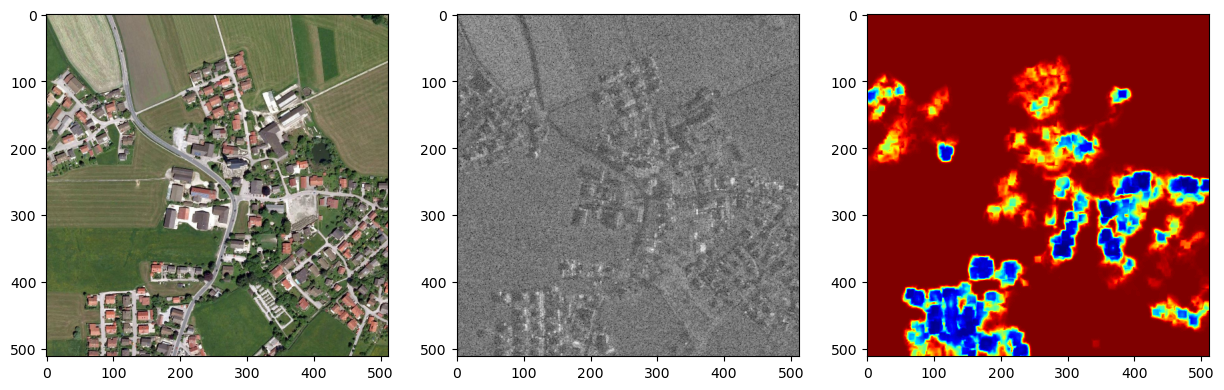

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(eo)
plt.subplot(1, 3, 2)
plt.imshow(T(sar), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(weights, cmap='jet')
# plt.colorbar()

### Bilateral Filtering

In [13]:
from scripts.parallelisation import extract_patches


class BF:
    """Guided Bilateral Filter (GBF)."""

    def _compute_luminance_weights(self, 
                                    luminance: jnp.ndarray, 
                                    radius: int, 
                                    lmbda: float,
                                    euclidian_distance: bool = True) -> jnp.ndarray:
        """
        Compute the luminance weights.

        Parameters:
        luminance : jnp.ndarray
            The luminance map of shape (H, W).
        radius : int
            The radius of the Gaussian kernel.
        lmbda : float
            The weight for the luminance kernel.
        euclidian_distance : bool
            If True, use Euclidean distance for luminance weighting. Else, use the SAR-domain range distance.

        Returns:
        jnp.ndarray
            The computed luminance weights of shape (H, W, k, k).
        """
        eps = 1e-10
        H, W = luminance.shape[:2]
        kernel_size = 2 * radius + 1  # k = 2 * r + 1
        patches = extract_patches(luminance, kernel_size, start_index=(0, 0), end_indices=(H, W))   # (H, W, k, k)
        centers = patches[..., radius, radius]  # (H, W)
        centers = centers[..., None, None] # (H, W, 1, 1)

        if euclidian_distance:
            distance = (patches - centers)**2  # (H, W, k, k)
        else:
            distance = jnp.log2(patches / (centers + eps) - centers / (patches + eps))  # (H, W, k, k)

        weights = jnp.exp(-lmbda * distance)  # (H, W, k, k)
        return weights

    def _compute_gaussian_weights(self, radius: int, lmbda: float) -> jnp.ndarray:
        """
        Compute the normalized Gaussian weights for the spatial domain.

        Parameters:
        radius : int
            The radius of the Gaussian kernel.
        lmbda : float
            The weight for the Gaussian kernel.

        Returns:
        jnp.ndarray
            The normalized Gaussian weights of shape (k, k).
        """
        x = jnp.arange(-radius, radius + 1)
        kernel = jnp.exp(-lmbda * (x * x))
        kernel = kernel / sum(kernel)
        kernel = kernel.reshape(-1, 1)
        return kernel @ kernel.T

    def filter(self, 
                sar: jnp.ndarray, 
                opt: jnp.ndarray, 
                window_size: int = 31, 
                lambda_S: float = 0.005, 
                lambda_RO: float = 0.02, 
                lambda_RS: float = 0.1,
                euclidian_distance: bool = True) -> jnp.ndarray:
        """
        Apply filter.

        Parameters
        sar : jnp.ndarray
            Input tensor of shape (H, W).
        opt : jnp.ndarray
            Luminance tensor of shape (H, W).
        window_size : int
            Size of the square kernel (must be odd).
        lambda_S : float
            Weight for spatial Gaussian kernel.
        lambda_RO : float
            Weight for optical luminance kernel.
        lambda_RS : float
            Weight for SAR luminance kernel.
        euclidian_distance : bool
            If True, use Euclidean distance for luminance weighting. Else, use the SAR-domain range distance.

        Returns
        jnp.ndarray
            Filtered tensor of shape (H, W).
        """
        radius = int(window_size // 2)  # r
        H, W = sar.shape[:2]

        # Pad the input arrays to handle borders
        pad_width = ((radius, radius), (radius, radius))
        sar_padded = jnp.pad(sar.copy(), pad_width, mode='reflect')  # (H', W'), with H' = H + 2*r and W' = W + 2*r
        opt_padded = jnp.pad(opt.copy(), pad_width, mode='reflect')  # (H', W')

        # Extract patches from the SAR image
        sar_patches = extract_patches(sar_padded, window_size, start_index=(0, 0), end_indices=sar_padded.shape[:2])  # (H', W', k, k), corresponds to v(s) in Eq. 1

        # Precompute Gaussian weights
        w_S = lambda_S * self._compute_gaussian_weights(radius, lambda_S).reshape(1, 1, window_size, window_size)  # (1, 1, k, k)
        w_RO = lambda_RO * self._compute_luminance_weights(opt_padded, radius, lambda_RO, euclidian_distance=True)   # (H', W', k, k)
        w_RS = lambda_RS * self._compute_luminance_weights(sar_padded, radius, lambda_RS, euclidian_distance=euclidian_distance)  # (H', W', k, k)

        # Combine weights
        w = w_S * w_RO * w_RS  # (H', W', k, k), corresponds to w(s, t) in Eq. 1, computed as Eq. 3
        w = w / (w.sum(axis=(-2, -1), keepdims=True) + 1e-10)

        # Filter
        sar_filtered = (w * sar_patches).sum(axis=(-2, -1))  # (H', W')

        # Unpad to get output of shape (H, W)
        return sar_filtered[radius:H+radius, radius:W+radius]  # (H, W)

In [14]:
bf = BF()

sar_filtered_bf = bf.filter(T(sar).squeeze(), eo.mean(axis=-1).squeeze(), euclidian_distance=True)

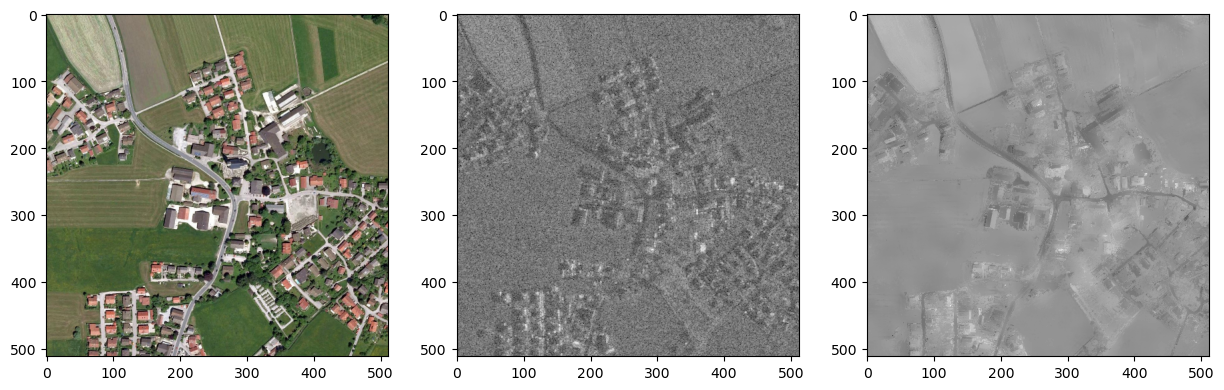

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(eo)
plt.subplot(1, 3, 2)
plt.imshow(T(sar), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(T(sar_filtered_bf), cmap='gray')

### Combinaison

In [18]:
mean_value = (sar_filtered_bf.mean() + T(sar_filtered_sarbm3d).mean()) / 2
sar_filtered_bf_2 = sar_filtered_bf - sar_filtered_bf.mean() + mean_value
sar_filtered_sarbm3d_2 = T(sar_filtered_sarbm3d) - T(sar_filtered_sarbm3d).mean() + mean_value

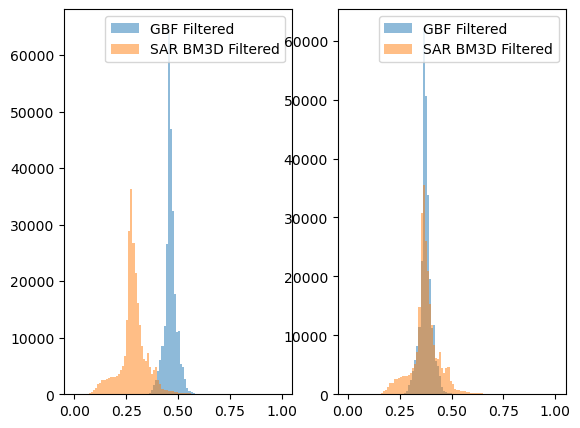

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.hist(sar_filtered_bf.flatten(), bins=100, range=(0, 1), label='GBF Filtered', alpha=0.5);
plt.hist(T(sar_filtered_sarbm3d).flatten(), bins=100, range=(0, 1), label='SAR BM3D Filtered', alpha=0.5);
plt.legend();
plt.subplot(1, 3, 2)
plt.hist(sar_filtered_bf_2.flatten(), bins=100, range=(0, 1), label='GBF Filtered', alpha=0.5);
plt.hist(sar_filtered_sarbm3d_2.flatten(), bins=100, range=(0, 1), label='SAR BM3D Filtered', alpha=0.5);
plt.legend();

In [27]:
uO = sar_filtered_bf_2
uS = sar_filtered_sarbm3d_2

sar_filtered = weights * uO + (1 - weights) * uS
sar_filtered = sar_filtered - sar_filtered.mean() + T(sar).mean()

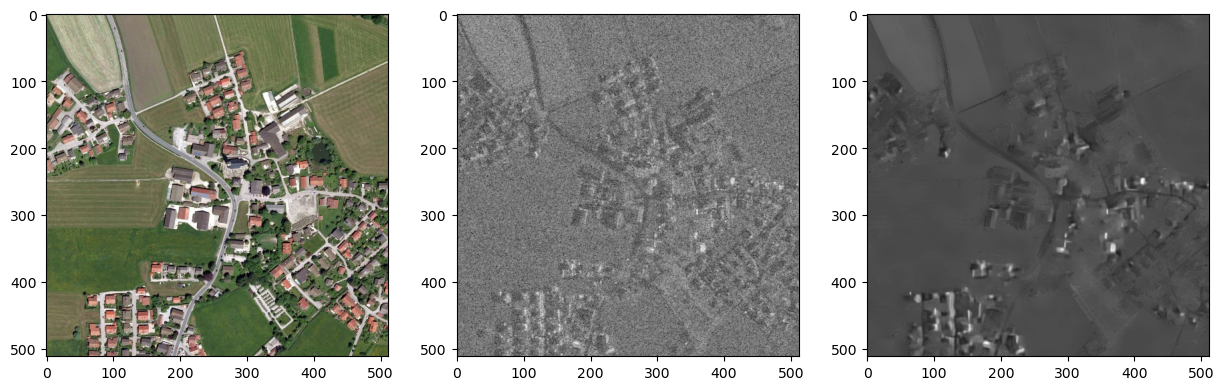

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(eo)
plt.subplot(1, 3, 2)
plt.imshow(T(sar), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(sar_filtered, cmap='gray')

In [ ]:
plt.imsave(Path.home() / 'Downloads' / 'output_village_gbf.png', sar_filtered, dpi=300)

In [38]:
output_path = str(Path.home() / 'workspace/despeckling/despeckling/methods/gbf/results' / 'output_village_gbf.mat')

save_image(output_path, sar_filtered, key=KEY_OUTPUT_SAR)

### BF

In [10]:
input_sar.shape, rgb2gray(input_eo).shape

((512, 512), (512, 512))

In [12]:
gbf = BF()

# sar_filtered_gbf = gbf.filter(input_sar[..., None], rgb2gray(input_eo)[..., None], euclidian_distance=False)

In [14]:
input_eo = jnp.array(eo, dtype=jnp.float32)
input_sar = jnp.array(sar, dtype=jnp.float32)

gbf = BF()
lambda_S = 0.005
lambda_RO = 0.02
lambda_RS = 0.1

sigma_spatial = gbf.lmbda2sigma(lambda_S)
sigma_guides = [gbf.lmbda2sigma(lambda_RO), gbf.lmbda2sigma(lambda_RS)]

sigma_spatial, sigma_guides

(Array(10., dtype=float32, weak_type=True),
 [Array(5., dtype=float32, weak_type=True),
  Array(2.236068, dtype=float32, weak_type=True)])

In [20]:
input_sar.shape, input_eo.shape, input_sar[..., None].shape, rgb2gray(input_eo)[..., None].shape

((512, 512), (512, 512, 3), (512, 512, 1), (512, 512, 1))

In [23]:
from scripts.parallelisation import compute_indices_from_n_blocks
from tqdm import tqdm

In [25]:
target = input_sar[..., None]  # (H, W, D)
guides = [rgb2gray(input_eo)[..., None], input_sar[..., None]]  # (H, W, 1)

H, W, _ = target.shape
radius = int(3 * sigma_spatial)  # r
kernel_size = 2 * radius + 1  # k = 2 * r + 1

target, guides = gbf._initialize_inputs(target, guides, radius)

# Precompute Gaussian weights
gaussian_weights = gbf._compute_gaussian_weights(radius)  # (1, 1, k, k, 1)
gaussian_weights.shape

(1, 1, 61, 61, 1)

In [27]:
# Compute start and end indices for memory efficiency
start_indices, end_indices = compute_indices_from_n_blocks(10, H, W, padding=radius)

In [30]:
errors = []
update = jnp.zeros_like(target)  # Initialize update tensor

update.shape

(572, 572, 1)

In [ ]:
# Iterate over the blocks
for start_index, end_index in zip(start_indices, end_indices):
    update = gbf._loop_over_blocks(
        start_index=start_index,
        end_index=end_index,
        target=target,
        update=update,
        guides=guides,
        sigmas=sigma_guides,
        gammas=[1, 1],
        gaussian_weights=gaussian_weights,
        kernel_size=kernel_size,
        euclidian_distance=False,
    )

In [29]:
update.shape

(28, 28, 61)

In [ ]:
# Update
target, error = gbf._update(target=target, update=update, alpha=1)
errors.append(error)

# Unpad to get output of shape (H, W, D)
target = target[radius:-radius, radius:-radius, :]  # (H, W, D)

In [22]:
gbf.uO = gbf.filter(
    input_sar[..., None], 
    [rgb2gray(input_eo)[..., None], input_sar[..., None]],
    sigma_spatial=sigma_spatial, 
    sigma_guides=sigma_guides, 
    n_iterations=1, 
    n_blocks=10, 
    euclidian_distance=False
)

Iterations:   0%|          | 0/1 [00:23<?, ?it/s]


TypeError: sub got incompatible shapes for broadcasting: (28, 28, 61), (572, 572, 1).

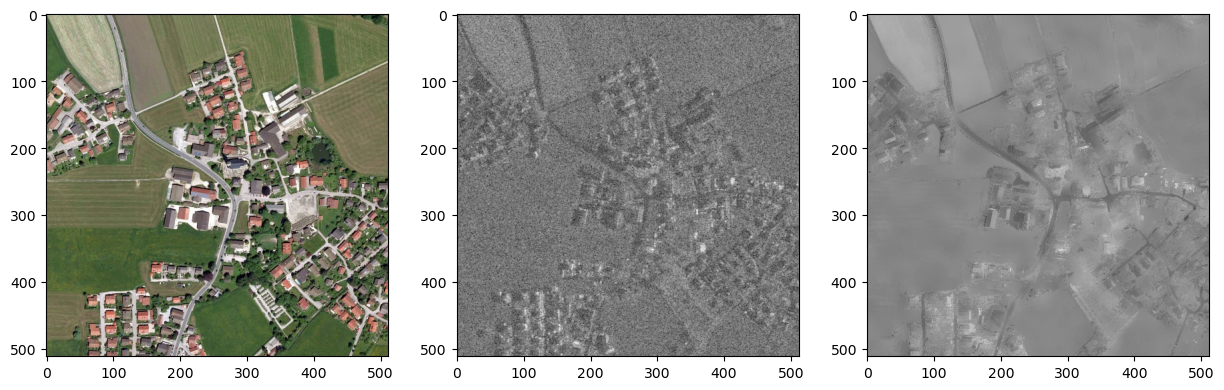

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(eo)
plt.subplot(1, 3, 2)
plt.imshow(T(sar), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(sar_filtered_gbf, cmap='gray')

### Despeckling

In [ ]:
uO = sar_filtered_gbf.squeeze()
uS = sar_filtered_sarbm3d.squeeze()
ft = weights

uO.min(), uO.max(), uS.min(), uS.max()

In [ ]:
sar_despeckled = ft * Norm(uO) + (1 - ft) * Norm(uS)

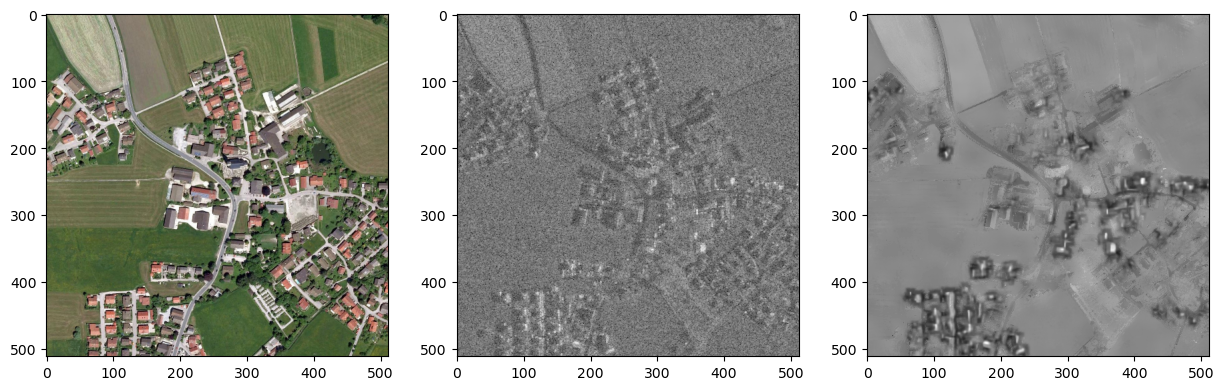

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(eo)
plt.subplot(1, 3, 2)
plt.imshow(T(sar), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(sar_despeckled, cmap='gray')

In [ ]:
output_path = Path().home() / 'workspace/despeckling/despeckling/methods/gbf/results/output.mat'

save_image(str(output_path), sar_despeckled, key=KEY_OUTPUT_SAR)